Calculate functionals with symbolics 
create kernel 

Create points 

construnct distance tnsors 


apply kernel to a distance tensor 

assemble RHS and matrices 

Assemble DAE 

Solve with diffeq.jl or custom code 





In [1]:
using Revise
using CairoMakie
using Symbolics
using Latexify
using DifferentialEquations
using Sundials
cd("..")
include("RBFunctions.jl")
cd("circular_stokes_flow")

In [148]:
@variables ϵ r x₁ x₂ t;
const nu = 1.0
#ϕ = 1//945 * ((ϵ*r)^5 +15*(ϵ*r)^3 + 105*(ϵ*r)^2 + 945*(ϵ*r)+ 945)* exp(-ϵ*r)
ϕ = exp(-r^2*ϵ^2)
ϕ = substitute(ϕ, r=>sqrt(x₁^2 + x₂^2)) 
#display(ϕ)  
Δ(exprs) = expand_derivatives((Differential(x₁)^2)(exprs) + (Differential(x₂)^2)(exprs))
∂₁(exprs) = expand_derivatives(Differential(x₁)(exprs))
∂₂(exprs) = expand_derivatives(Differential(x₂)(exprs))
∂ₜ(exprs) = expand_derivatives(Differential(t)(exprs))

Φ_div = ([-∂₂(∂₂(ϕ)) ∂₁(∂₂(ϕ)) 0.0 ; ∂₁(∂₂(ϕ)) -∂₁(∂₁(ϕ)) 0.0; 0.0 0.0 ϕ])
ΔΦ_div= Δ.([-∂₂(∂₂(ϕ)) ∂₁(∂₂(ϕ)); ∂₁(∂₂(ϕ)) -∂₁(∂₁(ϕ))])
Φ_curl = ([-∂₁(∂₁(ϕ)) -∂₁(∂₂(ϕ)); -∂₁(∂₂(ϕ)) -∂₂(∂₂(ϕ))])
Φ = [ϕ 0.0 0.0; 0.0 ϕ 0.0;0.0 0.0 ϕ]
#ΔΦ = [Δ(ϕ) 0 ; 0 Δ(ϕ)]
true_u = -x₂*π*sin(π*0.5*(x₁*x₁ + x₂*x₂))*sin(π*t)
true_v =  x₁*π*sin(π*0.5*(x₁*x₁ + x₂*x₂))*sin(π*t)
true_∂ₜu = ∂ₜ(true_u)
true_∂ₜv  = ∂ₜ(true_v)
true_p = sin(x₁-x₂+t)
true_∂₁p = ∂₁(true_p)
true_∂₂p = ∂₂(true_p)
f₁ = ∂ₜ(true_u) - nu*Δ(true_u) + true_∂₁p
f₂ = ∂ₜ(true_v) - nu*Δ(true_v) + true_∂₂p


true_u = eval(build_function(true_u,x₁, x₂, t))
true_v = eval(build_function(true_v,x₁, x₂, t))
true_p = eval(build_function(true_p,x₁, x₂, t))
true_∂₁p = eval(build_function(true_∂₁p,x₁, x₂, t))
true_∂₂p = eval(build_function(true_∂₂p,x₁, x₂, t))
f₁ = eval(build_function(f₁,x₁, x₂, t))
f₂ = eval(build_function(f₂,x₁, x₂, t))
∂ₜu = eval(build_function(true_∂ₜu,x₁, x₂, t))
∂ₜv  = eval(build_function(true_∂ₜv,x₁, x₂, t))
zero_func(x₁,x₂,t) = 0.0
#display(Φ)
#display(Φ[1,:])
λ₁(x) = x[1]
λ₂(x) = x[2]
λ₃(x) = x[3]
λ₄(x) = x[1]
λ₅(x) = x[2]

λ∂ₜu1(x) = Δ(x[1]) - ∂₁(x[3]) # functional applied to the 1st variable 
λ∂ₜv1(x) = Δ(x[2]) - ∂₂(x[3]) 

λ∂ₜu2(x) = Δ(x[1]) + ∂₁(x[3]) # functional applied to the 2nd variable 
λ∂ₜv2(x) = Δ(x[2]) + ∂₂(x[3]) 


λ∇u(x) = ∂₁(x[1]) + ∂₂(x[2]) 
λ∂₁p(x)  = ∂₁(x[3])
λ∂₂p(x)  = ∂₂(x[3])

function construct_kernel_array(matrix_kernel,functionals1,functionals2)
    N1 = length(functionals1)
    N2 = length(functionals2)
    M = Matrix{typeof(matrix_kernel[1,1])}(undef,N1,N2)
    for j = 1:N2
        λⱼ = functionals2[j]
        v = [λⱼ(matrix_kernel[1,:]),λⱼ(matrix_kernel[2,:]),λⱼ(matrix_kernel[3,:])]
        for i = 1:N1
            λᵢ = functionals1[i]
            M[i,j] = λᵢ(v)
        end
    end
    return M 
end

function compile_kernel_array(M)
    N1 = size(M)[1]
    N2 = size(M)[2]
    P = Matrix{Function}(undef,N1,N2)
    for i = 1:N1
        for j = 1:N2
            #display(M[i,j])
            P[i,j] = eval(build_function(M[i,j], [x₁, x₂], ϵ))
        end
    end
    return P
end

function crete_block_point_tensors(p_list1,p_list2)
    N1 = length(p_list1)
    N2 = length(p_list2)
    M = Matrix{Array{Float64, 3}}(undef,N1,N2)
    for i in 1:N1
        for j in 1:N2
            M[i,j] = point_difference_tensor(p_list1[i],p_list2[j])
        end
    end

    return M
end
#point_difference_tensor(Internal_points,Internal_points)
function generate_block_matrices(function_array,tensor_array,param)
    n1,n2 = size(tensor_array)
    if size(tensor_array) != size(function_array)
        return ArgumentError("function array and tensor array size mismatch")
    end
    M = Matrix{Matrix}(undef,n1,n2)
    for i in 1:n1
        for j in 1:n2
            #display(function_array[i,j])
            #display(tensor_array[i,j])
            M[i,j] = apply(function_array[i,j], tensor_array[i,j], param)
        end
    end
    return M
end
function flatten(block_matrix)
    # flattens block matrices into usual matrices 
    n1,n2 = size(block_matrix)
    res = hcat(block_matrix[1,:]...)
    #println(size(res))
    for i in 2:n1
        row  = hcat(block_matrix[i,:]...)
        res = vcat(res,row)
        #println(size(row))
    end
    return res
end


flatten (generic function with 1 method)

In [135]:
#generate points for circular flow benchmark 
using DistMesh2D
fdistance(p) = sqrt(sum(p .^ 2)) - 1
fedgelength(p) = 1#/(sqrt(sum(p .^ 2))+1)
boundingbox = [-1.1 -1.1; 1.1 1.1]
initdistance = 0.1
x, y = distmesh2d(fdistance, fedgelength, boundingbox, initdistance)

# generate points, reference solution, forcing vector, and boundary conditions 
tx = unique(filter(e -> !isequal(e,NaN) ,x))
ty = unique(filter(e -> !isequal(e,NaN) ,y))

points = hcat(tx,ty)'

Internal_points = []
Boundary_points = []
suma = 0
for i in 1:length(tx)
    if abs(sum(points[:,i] .^2) - 1) < 1e-8
        #println(i)
        suma +=1
        append!(Boundary_points,[points[:,i]])
    else
        append!(Internal_points,[points[:,i]])
    end
    
end

Internal_points = hcat(Internal_points...)
Boundary_points = hcat(Boundary_points...)
All_points = hcat(Internal_points,Boundary_points)
N_i = size(Internal_points)[2]
N_b = size(Boundary_points)[2]
N = N_i + N_b
println("total number of nodes: ",N)
println("number og internal_nodes: ",N_i)

total number of nodes: 358
number og internal_nodes: 308


In [149]:
param = 5
K_symbolic = construct_kernel_array(Φ_div,[λ₁,λ₂,λ₄,λ₅],[λ∂ₜu2,λ∂ₜv2,λ₄,λ₅])
S_symbolic = construct_kernel_array(Φ_div,[λ∂ₜu1,λ∂ₜv1],[λ∂ₜu2,λ∂ₜv2,λ₄,λ₅])
∇P_symbolic = construct_kernel_array(Φ_div,[λ∂₁p,λ∂₂p],[λ∂ₜu2,λ∂ₜv2,λ₄,λ₅])

display(K_symbolic)
display(S_symbolic)

K_compiled = compile_kernel_array(K_symbolic)
S_compiled = compile_kernel_array(S_symbolic)
∇P_compiled = compile_kernel_array(∇P_symbolic)


K_ = crete_block_point_tensors([Internal_points,Internal_points,Boundary_points,Boundary_points],
[Internal_points,Internal_points,Boundary_points,Boundary_points])
S_= crete_block_point_tensors([Internal_points,Internal_points],
[Internal_points,Internal_points,Boundary_points,Boundary_points])

K = flatten(generate_block_matrices(K_compiled,K_,param))
S = flatten(generate_block_matrices(S_compiled,S_,param))
∇P = flatten(generate_block_matrices(∇P_compiled,S_,param))
println("cond K: ",cond(K))
C = S*inv(K)
A = C[:,1:2*N_i]
B = C[:,2*N_i+1:end]
E = zeros((3*N_i,3*N_i))
E[1:2*N_i,1:2*N_i] = I(2*N_i)
#display(A)
#display(B)
#display(E)

println("condition A: ",cond(A))
println("max eigenval: ",maximum(real.(eigvals(A))))
"""assemble RHS vectors"""
f = generate_vector_function([f₁,f₂],Internal_points)
g= generate_vector_function(true_u,true_v,Boundary_points;Mixed=false)
u_true = generate_vector_function(true_u,true_v,Internal_points;Mixed=false)
p_true = generate_vector_function(true_p,Internal_points)
∇p_true = generate_vector_function([true_∂₁p,true_∂₂p],Internal_points)
sol_true = generate_vector_function([f₁,f₂,true_p],Internal_points)
#display(A[2*N_i+1:end,2*N_i+1:end])
minimum(abs.(inv(A)))

4×4 Matrix{Num}:
     (8//1)*(x₁^2)*(ϵ^6)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) + (56//1)*(x₂^2)*(ϵ^6)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) - (16//1)*(ϵ^4)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) - (16//1)*(x₂^4)*(ϵ^8)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) - (16//1)*(x₁^2)*(x₂^2)*(ϵ^8)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2))  …  (4//1)*x₁*x₂*(ϵ^4)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2))
 (16//1)*x₁*(x₂^3)*(ϵ^8)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) + (16//1)*x₂*(x₁^3)*(ϵ^8)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) - (48//1)*x₁*x₂*(ϵ^6)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2))                                                                                                                           (2//1)*(ϵ^2)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) - (4//1)*(x₁^2)*(ϵ^4)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2))
     (8//1)*(x₁^2)*(ϵ^6)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) + (56//1)*(x₂^2)*(ϵ^6)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) - (16//1)*(ϵ^4)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) - (16//1)*(x₂^4)*(ϵ^8)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) - (16//1)*(x₁^2)

2×4 Matrix{Num}:
             (2//1)*(ϵ^2)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) + (192//1)*(ϵ^6)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) + (32//1)*(x₁^4)*(ϵ^10)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) + (544//1)*(x₂^4)*(ϵ^10)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) + (576//1)*(x₁^2)*(x₂^2)*(ϵ^10)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) - (4//1)*(x₁^2)*(ϵ^4)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) - (192//1)*(x₁^2)*(ϵ^8)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) - (64//1)*(x₂^6)*(ϵ^12)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) - (960//1)*(x₂^2)*(ϵ^8)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) - (128//1)*(x₁^2)*(x₂^4)*(ϵ^12)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) - (64//1)*(x₁^4)*(x₂^2)*(ϵ^12)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2))  …  (16//1)*x₁*(x₂^3)*(ϵ^8)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) + (16//1)*x₂*(x₁^3)*(ϵ^8)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) - (48//1)*x₁*x₂*(ϵ^6)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2))
 (64//1)*x₂*(x₁^5)*(ϵ^12)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) + (64//1)*x₁*(x₂^5)*(ϵ^12)*exp(-(ϵ^2)*(sqrt(x₁^2 + x₂^2)^2)) + (128//1)*(x₁^3)*(x₂^3)*(ϵ^1

cond K: 5.82203687370268e12
condition A: 2.2462426617744956e9
max eigenval: -14.674031926481122


1.8242474452487618e-11

In [181]:

u0 = u_true(0)
#display(u0)
t_interval = (0.0,10)
function stokes(du, u, p, t)
    A,B,g,f = p
    du .= A * u .+ B * g(t) .+ f(t)
    nothing
end
func = ODEFunction(stokes)
prob = ODEProblem(func, u0, t_interval, [A,B,g,f])
sol = solve(prob, ABDF2())


retcode: Success
Interpolation: 3rd order Hermite
t: 394-element Vector{Float64}:
  0.0
  3.826356318351685e-9
  7.65271263670337e-9
  4.5916275820220216e-8
  4.285519076553887e-7
  2.319904647275856e-6
  5.647540547623657e-6
  7.151568276334228e-6
  1.2279741399742682e-5
  1.7780599344543903e-5
  2.3949636990047762e-5
  3.011867463555162e-5
  3.865699863028639e-5
  ⋮
  9.729372367099085
  9.775661622268123
  9.786546115013257
  9.808871444763135
  9.846973307889352
  9.85681688733006
  9.880060980076331
  9.912397538520723
  9.938534832592929
  9.964672126665134
  9.984210106546467
 10.0
u: 394-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [2.9567122000975013e-8, 3.1099963663967566e-8, 3.553524622017387e-8, 3.324405430368571e-8, 2.7401274736475196e-8, 3.546027706524722e-8, 3.038523686936035e-8, 2.5236878284027965e-8, 2.3958236131581927e-8, 2.9731443097648554e-8  …  4.132383291281238e-10, 3.12

0.07715397948117503
0.12444769605083916
1.4294120332523947e-15
0.07715397948117637
max error all time: 0.14073597049431008


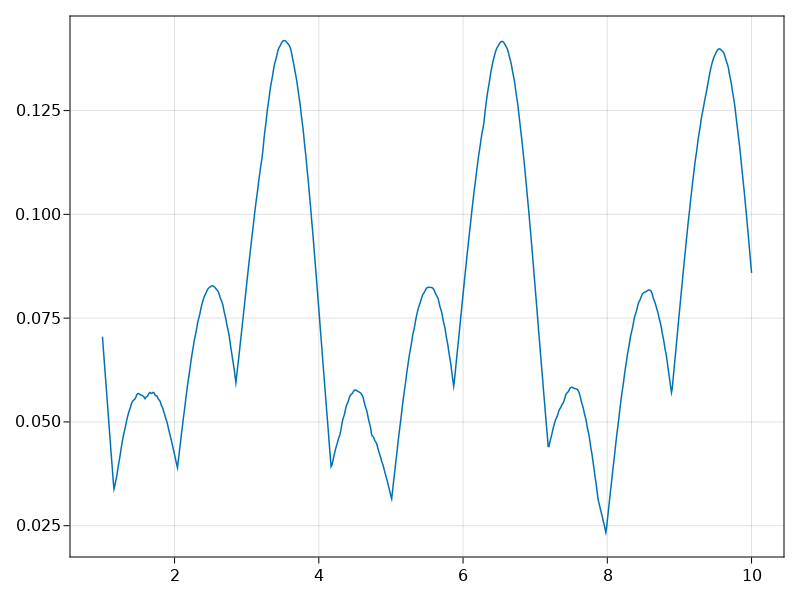

In [184]:
tt = 4
println(maximum(abs.(sol(tt)[1:2*N_i] .- u_true(tt))))
#display(vcat(sol.(0.0:0.01:2.0)...))
#display(vcat(u_true.(0.0:0.01:2.0)...))
println(maximum(vcat(sol.(0.0:0.01:2.0)...) .- vcat(u_true.(0.0:0.01:2.0)...)))
println(maximum(u_true(tt)))
println(maximum(sol(tt)))
println("max error all time: ",max_error(sol,u_true,N_i*2))
lines(1:0.01:10,[maximum(abs.(sol(tt)[1:2*N_i] .- u_true(tt))) for tt in 1:0.01:10])

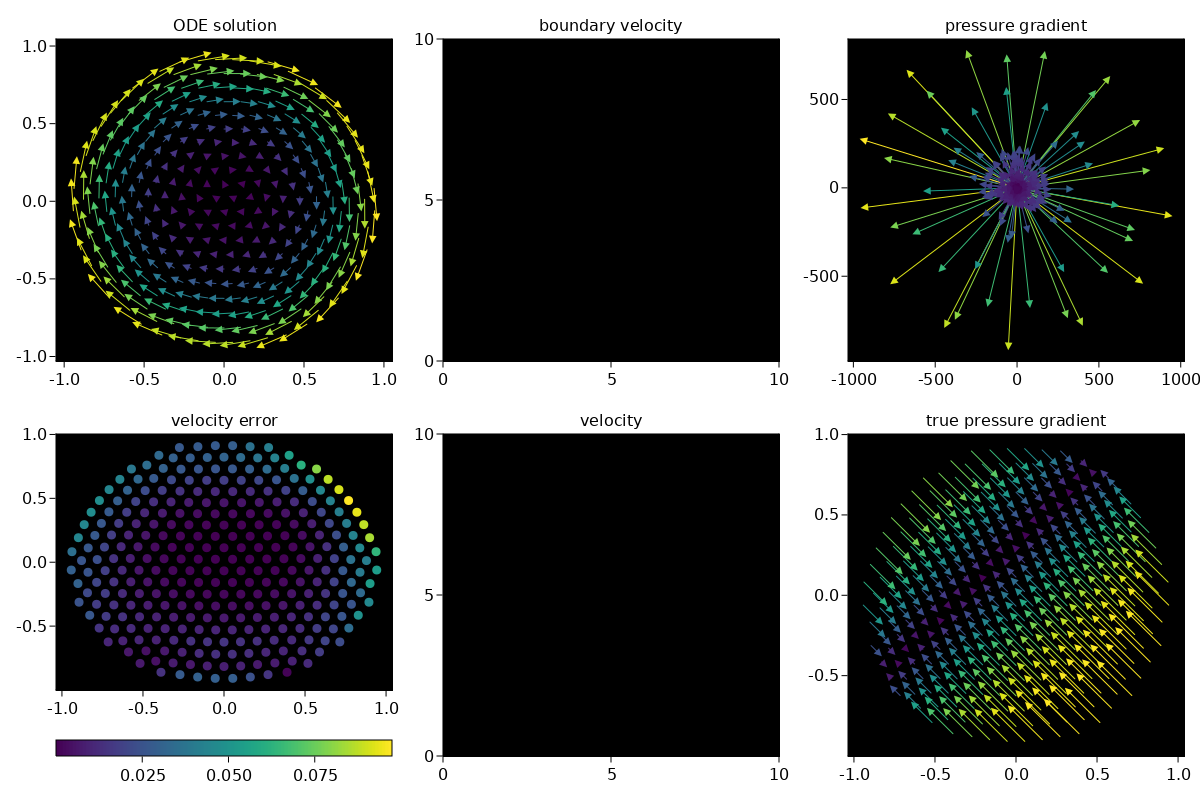

In [162]:
t_interest = 1.9
xsi = Internal_points[1,:]
ysi = Internal_points[2,:]

u = sol(t_interest)[1:N_i]
v = sol(t_interest)[N_i+1:end]

#usi = f(t_interest)[1:2:2*N_i]
#vsi = f(t_interest)[2:2:2*N_i]

up = ∇p_true(t_interest)[1:N_i]
vp = ∇p_true(t_interest)[N_i+1:end]

up_sol = (∇P * inv(K) * vcat(sol(t_interest),g(t_interest)))[1:N_i]
vp_sol = (∇P * inv(K) * vcat(sol(t_interest),g(t_interest)))[N_i+1:2*N_i]

error = (sol(t_interest)[1:N_i] .^2  .+ sol(t_interest)[1+N_i:end] .^2) - (u_true(t_interest)[1:N_i] .^2  .+ u_true(t_interest)[1+N_i:end] .^2)
error = abs.(error)
#xsb = Boundary_points[1,:]
#ysb = Boundary_points[2,:]
#usb = g(t_interest)[1:2:2*N_b]
#vsb = g(t_interest)[2:2:2*N_b]

#strengthi = (sqrt.( usi.^ 2 .+  vsi.^ 2) )
#strengthb = (sqrt.( usb.^ 2 .+  vsb.^ 2) )
strengthp = (sqrt.( (up.+0.0).^ 2 .+  (vp .+0.0).^ 2) )
strengthp_sol = (sqrt.( (up_sol.+0.0).^ 2 .+  (vp_sol .+0.0).^ 2) )
strengthsol = (sqrt.( (u.+0.0).^ 2 .+  (v .+0.0).^ 2) )

fig = Figure(resolution = (3*400, 2*400))
subfig1 = fig[1, 1] = GridLayout()
subfig2 = fig[1, 2] = GridLayout()
subfig3 = fig[1, 3] = GridLayout()
subfig4 = fig[2, 1] = GridLayout()
subfig5 = fig[2, 2] = GridLayout()
subfig6 = fig[2, 3] = GridLayout()
ax1 = Axis(subfig1[1, 1], backgroundcolor = "black",title = "ODE solution")
ax2 = Axis(subfig2[1, 1], backgroundcolor = "black",title = "boundary velocity")
ax3 = Axis(subfig3[1, 1], backgroundcolor = "black",title = "pressure gradient")
ax4 = Axis(subfig4[1, 1], backgroundcolor = "black",title = "velocity error")
ax5 = Axis(subfig5[1, 1], backgroundcolor = "black",title = "velocity")
ax6 = Axis(subfig6[1, 1], backgroundcolor = "black",title = "true pressure gradient")
#arrows!(ax1,xsi, ysi, usi, vsi, arrowsize = 10, lengthscale = 0.2, arrowcolor = strengthi, linecolor = strengthi) #,
arrows!(ax3,xsi, ysi, up_sol, vp_sol, arrowsize = 10, lengthscale = 0.2, arrowcolor = strengthp_sol, linecolor = strengthp_sol) #,
arrows!(ax6,xsi, ysi, up, vp, arrowsize = 10, lengthscale = 0.2, arrowcolor = strengthp, linecolor = strengthp) #,
arrows!(ax1,xsi, ysi,u , v, arrowsize = 10, lengthscale = 0.2, arrowcolor = strengthsol, linecolor = strengthsol)
scatter!(subfig4[1, 1],xsi,ysi, color = error)
Colorbar(subfig4[2, 1], limits = (minimum(error), maximum(error)), vertical = false, flipaxis = false)
fig
#save("testingg.png",fig)

#display(up_sol)

In [51]:
time = Observable(0.0)
xs = Internal_points[1,:]
ys = Internal_points[2,:]
us = @lift sol($time)[1:N_i] #- u_true($time)[1:N_i]
vs = @lift sol($time)[N_i+1:end]  #- u_true($time)[N_i+1:end] 
title = @lift string(round($time, digits=2))
strength2 = @lift sqrt.(sol($time+0.01)[1:N_i] .^ 2 .+ sol($time+0.01)[N_i+1:end] .^ 2) 

fig = Figure(resolution = (800, 800))
Axis(fig[1, 1], backgroundcolor = "black",title = title)
arrows!(xs, ys, us, vs, arrowsize = 10, lengthscale = 0.1, arrowcolor = strength2, linecolor = strength2) #, 
framerate = 30
timestamps = range(0.0, 2, step=1/framerate)
record(fig, "ODE_method.gif", timestamps; framerate = framerate) do ti
    time[] = ti
end


"ODE_method.gif"

In [9]:
"""
# test the code on interpolation
M = construct_kernel_array(Φ_div,[λ₁,λ₂,λ₃],[λ₁,λ₂,λ₃])
O = compile_kernel_array(M)
int_points = hcat(generate_2D_equally_spaced_points(10)...)
tst_points, _ =  generate_2D_equally_spaced_points(20)
u₁_int = generate_vector_function(true_u₁,int_points)(1.3)
u₂_int = generate_vector_function(true_u₂,int_points)(1.3)
p_int = generate_vector_function(true_p,int_points)(1.3)

u₁_tst = generate_vector_function(true_u₁,tst_points)(1.3)
u₂_tst = generate_vector_function(true_u₂,tst_points)(1.3)
p_tst = generate_vector_function(true_p,tst_points)(1.3)


A_int = crete_block_point_tensors([int_points,int_points,int_points],[int_points,int_points,int_points])
A_tst = crete_block_point_tensors([tst_points,tst_points,tst_points],[int_points,int_points,int_points])
P_int = generate_block_matrices(O,A_int,2)
P_tst = generate_block_matrices(O,A_tst,2)
FF_int = flatten(P_int)
FF_tst = flatten(P_tst)

println("cond_number:", cond(FF_int))

reconstructed = FF_tst* (FF_int\ vcat(u₁_int,u₂_int,p_int))
error = reconstructed - vcat(u₁_tst,u₂_tst,p_tst)
fig, ax, hm = heatmap(tst_points[1,:],tst_points[2,:],error[324*2+1:324*3],aspect_ratio=:equal,colorbar=true)
Colorbar(fig[:, end+1], hm)
fig
"""

LoadError: syntax: invalid escape sequence